In [156]:
# import Libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler 
from random import sample
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [157]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

TensorFlow version: 2.6.2


In [158]:
train_path='../input/bird-vs-drone-new/BVD/Train'
val_path='../input/bird-vs-drone-new/BVD/Val'
test_path='../input/bird-vs-drone-new/BVD/Test'

In [159]:
df_train=pd.DataFrame(columns=['path','label'])
df_val=pd.DataFrame(columns=['path','label'])
df_test=pd.DataFrame(columns=['path','label'])

In [160]:
# list all the files and directories present in the directory.
# CHOOSE 1 OF THE CATEGORIES
categories = os.listdir(train_path)  
categories

['Bird', 'Drone']

In [161]:
IMAGE_SAMPLES=None      # Pass image samples as None to take all samples of images    

# creating a balanced dataset for training machine learning models.

def limit_data(data_dir,categories,n=None):
    a=[]
    for i in categories:
        for k,j in enumerate(os.listdir(data_dir+'/'+i)):
            if n!=None and k>=n:break;
            a.append((f'{data_dir}/{i}/{j}',i))
    return pd.DataFrame(a,columns=['path','label'])


df_train=limit_data(train_path,categories,IMAGE_SAMPLES)
df_val=limit_data(val_path,categories,IMAGE_SAMPLES)
df_test=limit_data(test_path,categories,IMAGE_SAMPLES)

In [162]:
df_train['label'].value_counts()

Drone    308
Bird     300
Name: label, dtype: int64

In [163]:
df_val['label'].value_counts()

Drone    60
Bird     50
Name: label, dtype: int64

In [164]:
df_test['label'].value_counts()

Drone    60
Bird     50
Name: label, dtype: int64

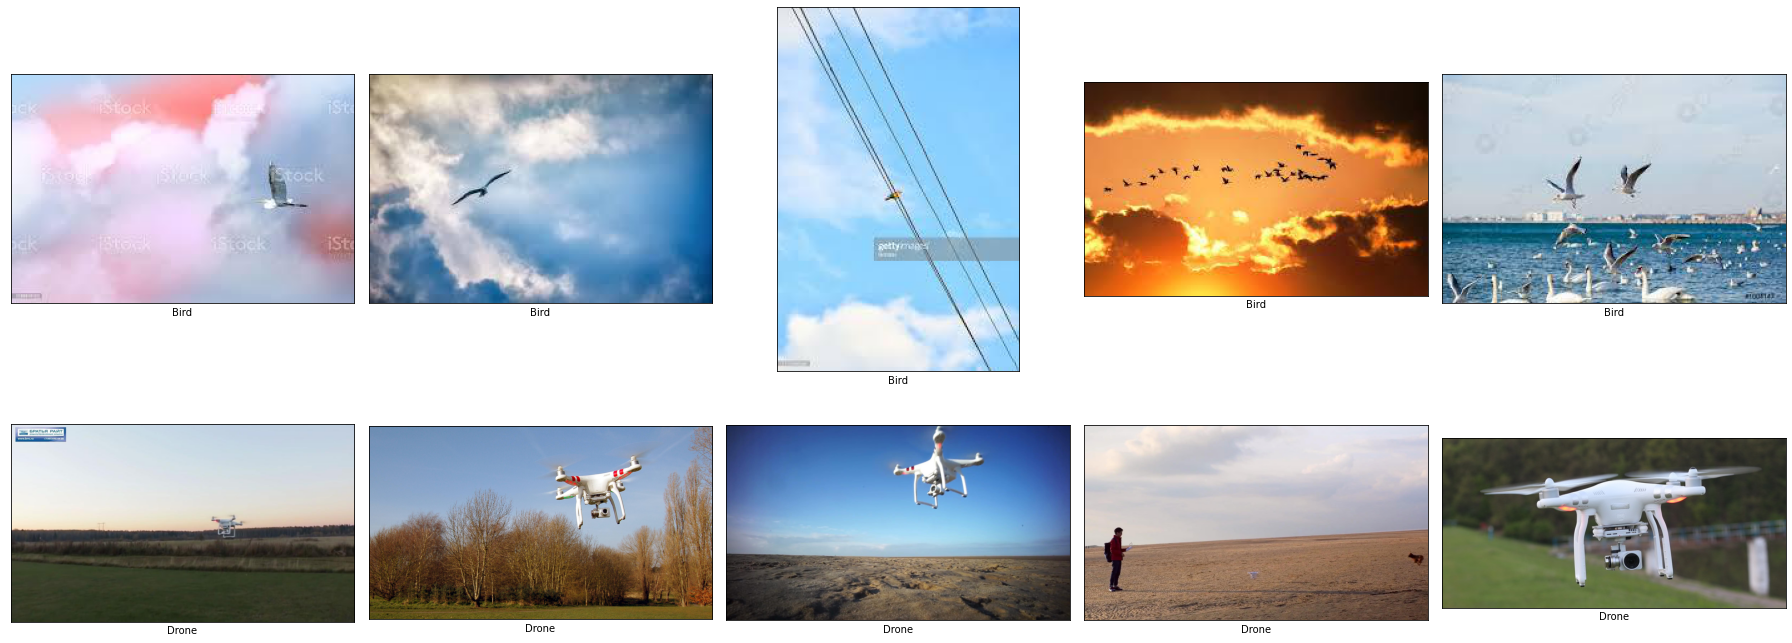

In [165]:
# Randomly display 5 images under each of the 4 categories from the training data.

fig, axs = plt.subplots(len(df_train['label'].unique()), 5, figsize = (25, 10))
for i,cat in enumerate(categories):
    path_cat=df_train[df_train['label']==cat].path.values[:5]        # take only 5 categories
    for j, path in enumerate(path_cat):
#         images = sample(df_train[item], 5)

        img = PIL.Image.open(path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = cat, xticks = [], yticks = [])

fig.tight_layout()

In [166]:
# Image generator with Augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    zoom_range = 0.2,
    horizontal_flip = True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8,1.0]
)

val_datagen=ImageDataGenerator(rescale=1./255)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)

In [167]:
# Split the data
train_data=train_datagen.flow_from_dataframe(df_train,x_col='path',y_col='label',target_size=(256, 256),batch_size=32,
                                             class_mode='binary',seed=42,shuffle = False) 
val_data=val_datagen.flow_from_dataframe(df_val,x_col='path',y_col='label',target_size=(256, 256),batch_size=32,
                                           class_mode='binary',seed=42,shuffle = False)
#test data
test_data=test_datagen.flow_from_dataframe(df_test,x_col='path',y_col='label',target_size=(256, 256),batch_size=32,
                                           class_mode='binary',seed=42,shuffle = False)

Found 606 validated image filenames belonging to 2 classes.
Found 110 validated image filenames belonging to 2 classes.
Found 110 validated image filenames belonging to 2 classes.


In [172]:
# Class labels
train_data

# Compact Convolutional Transformer - Simple Model

In [233]:
import tensorflow as tf
from tensorflow.keras import layers

def create_simple_cct_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Tokenize input patches
    patch_encoder = layers.Conv2D(64, kernel_size=3, strides=3, activation='relu')(inputs)
    patch_encoder = layers.Conv2D(128, kernel_size=3, strides=2, activation='relu')(patch_encoder)

    # Transformer encoder layers
    transformer_units = 128
    num_heads = 2
    for _ in range(2):  # You can adjust the number of transformer layers
        # Multi-head self-attention
        x1 = layers.LayerNormalization(epsilon=1e-5)(patch_encoder)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=transformer_units)(x1, x1)
        x2 = layers.Add()([attention_output, patch_encoder])

        # Feed-forward network
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        x3 = layers.Dense(units=transformer_units, activation='relu')(x3)
        x3 = layers.Dense(units=transformer_units)(x3)
        patch_encoder = layers.Add()([x3, x2])

    # Global average pooling
    representation = layers.GlobalAveragePooling2D()(patch_encoder)

    # Classification head
    outputs = layers.Dense(units=num_classes, activation='softmax')(representation)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
input_shape = (224, 224, 3)  # Define your input shape
num_classes = 1  # Define the number of output classes
cct_model = create_simple_cct_model(input_shape, num_classes)
# cct_model.summary()
cct_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = cct_model.fit(train_data, validation_data=val_data, epochs=50)

# Evaluate on test data
loss, accuracy = cct_model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.5083WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7c1e99172830> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
19/19 [==============================] - 13s 550ms/step - loss: 0.0000e+00 - a

# Training the MobileNetV2 model

In [ ]:
# Create an instance of the MobileNetV2 model with pre-trained weights (include_top=False for feature extraction)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a custom top model for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine the base model and top model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Combine the base model and top model
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
model.compile(loss='binary_crossentropy',
       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
       metrics=['accuracy','AUC'])

In [ ]:
history = model.fit(
    train_data,
    epochs=25,
    validation_data=val_data
#     callbacks=[lr_schedule]
)

In [ ]:
hist=history.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#Loss curve
hist=history.history
plt.plot(hist["loss"],color="b",label="train_loss")
plt.plot(hist["val_loss"],color="g",label="val_loss")
plt.legend(loc="upper right")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
model.evaluate(train_data)

In [ ]:
model.evaluate(val_data)

In [ ]:
model.evaluate(test_data)

In [ ]:
y_test_pred=model.predict(test_data)

In [ ]:
y_true=pd.Series(test_data.classes)
y_true

In [ ]:
print(len(y_test_pred))
# print(y_test_pred[:20])

In [ ]:
auc=metrics.roc_auc_score(y_true,y_test_pred)
auc

In [ ]:
# calculate roc curve
fpr, tpr, thresholds = metrics.roc_curve(y_true, y_test_pred)

#plot the roc curve
plt.plot(fpr,tpr,label="data 1, auc="+str(round(auc,2)))
plt.legend(loc=4)
plt.show()

# find optimal threshold
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]
# print("Threshold value is:", optimal_threshold)

In [ ]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
gmeans

In [ ]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
optimal_threshold=thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (optimal_threshold, gmeans[ix]))

In [ ]:
y_test_pred_index=[]
for i,pred in enumerate(y_test_pred):
    if pred>=optimal_threshold:
        y_test_pred_index.append(1)
    else:
        y_test_pred_index.append(0)
    
    
# print(y_test_pred_index)

In [ ]:
pd.Series(y_test_pred_index).value_counts()

In [ ]:
# Image generator with Augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    zoom_range = 0.2,
    horizontal_flip = True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.8,1.0]
)

val_datagen=ImageDataGenerator(rescale=1./255)

# For test data we only rescale the data.
# Never augment test data!!!
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
import itertools,matplotlib
from itertools import product

min_val, max_val = 0.3,1.0
n = 10
orig_cmap = plt.cm.Blues
colors = orig_cmap(np.linspace(min_val, max_val, n))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)


def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=cmap):

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm=confusion_matrix(y_true,y_test_pred_index)
print(cm)

In [ ]:
plot_confusion_matrix(cm,classes=categories)

In [ ]:
cnt=0
for i in range(len(y_true)):
    if y_true[i]==y_test_pred_index[i]:
        cnt+=1

print('acc:', cnt/len(y_true)*100)
    

In [ ]:
print(len(y_true))

In [ ]:
print(list(y_true))
print(y_test_pred_index)

In [ ]:
metrics.accuracy_score(y_true,y_test_pred_index)

In [ ]:
from sklearn.metrics import classification_report
target_names = categories

print(classification_report(y_true,y_test_pred_index, target_names=target_names))